# Ch3: Learning the Logic of DNA

In [23]:
import pandas as pd

path1 = r"C:\Users\justc\Documents\ml-study-notes\dlfb-clone\assets\dna\datasets\CTCF_train_sequences.csv"
train_df = pd.read_csv(path1)
train_df

,sequence,label,transcription_factor,subset
0,TACCACATGAGTTCTCTTTCAGTTTGCTATGGAAGACACAAAAACC...,1,CTCF,train
1,CATCAACACTCGTGCGACGCCCTCGCATTTTCATTAATGATGGCCT...,0,CTCF,train
2,GCACACAGCGCAGGAACCTGGCACTGGAGAAGCCACCCAGGCTGTG...,1,CTCF,train
3,GCCAGCCGAAGCAGAGAGCAGTGCACATGCGTGCAGCTACCAGCAT...,1,CTCF,train
4,GTCCCGTCCCTTTTCGTGCCTCTGCCCCCACAGCTGCTGCAGTCTG...,1,CTCF,train
...,...,...,...,...
61078,AATATGACCCTGCTGGCCTTAGGCCTACTCCTGTACCACAAGTGCC...,0,CTCF,train
61079,GATAAACCAAGGTCGTAAGTTCAGGCTCCGCCTCCCCGCAGGGCCT...,1,CTCF,train
61080,CCTCCCTCCCATCCCCCACACAGTTTAATGTCTAGAAGGTTGCCTG...,1,CTCF,train
61081,CAGGAATGCACCGGAAGTCCGCCTCCCGGGACCCGCCGCCGGTCCC...,0,CTCF,train


In [24]:
train_df["label"].value_counts()

label
1    30545
0    30538
Name: count, dtype: int64

# One-hot-encoding on DNA seuqnces

In [25]:
import numpy as np

def dna_to_one_hot(dna_sequence: str) -> np.ndarray:
    """Convert DNA into a one-hot encoded format with channel ordering ACGT."""
    base_to_one_hot = {
        "A": (1, 0, 0, 0),
        "C": (0, 1, 0, 0),
        "G": (0, 0, 1, 0),
        "T": (0, 0, 0, 1),
        "N": (1, 1, 1, 1), # N represents any unknown or ambiguous base
    }
    one_hot_encoded = np.array([base_to_one_hot[base] for base in dna_sequence])
    return one_hot_encoded

In [26]:
dna_to_one_hot("AAACGT")

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])

In [27]:
x_train = np.array([dna_to_one_hot(seq) for seq in train_df["sequence"]])
y_train = train_df["label"].values[:, None] # pyright: ignore[reportArgumentType, reportCallIssue]

In [28]:
x_train.shape

(61083, 200, 4)

In [29]:
def load_dataset(sequence_db) -> dict[str, np.ndarray]:
    """Load sequences and labels from a CSV into numpy arrays"""
    df = pd.read_csv(sequence_db)
    return {
        "labels": df["label"].to_numpy()[:, None],
        "sequences": np.array([dna_to_one_hot(seq) for seq in df["sequence"]]),
    }

In [ ]:
import tensorflow as tf
def convert_to_tfds(dataset, batch_size: int | None = None, is_training: bool = False):
    """Convert DNA sequences and labels to a TensorFlow dataset"""
    ds = tf.data.Dataset.from_tensor_slices(dataset)
    if is_training:
        ds = ds.shuffle(buffer_size=len(dataset["sequences"]))
        ds = ds.repeat()
    batch_size = batch_size or len(dataset["labels"])
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds 
batch_size = 32

train_ds = convert_to_tfds(
    load_dataset(r"C:\Users\justc\Documents\ml-study-notes\dlfb-clone\assets\dna\datasets\CTCF_train_sequences.csv"),
    batch_size = batch_size,
    is_training=True,
)

In [31]:
batch = next(train_ds.as_numpy_iterator())
print(f'Batch sequence shape: {batch["sequences"].shape}')
print(f'Batch sequence instances: {batch["sequences"][:3, :3, ]}...')
print(f'Batch labels shape: {batch["labels"].shape}')
print(f'Batch labels instances: {batch["labels"][:3,]}...')

Batch sequence shape: (32, 200, 4)
Batch sequence instances: [[[1 0 0 0]
  [0 0 1 0]
  [1 0 0 0]]

 [[0 1 0 0]
  [1 0 0 0]
  [0 1 0 0]]

 [[1 0 0 0]
  [1 0 0 0]
  [1 0 0 0]]]...
Batch labels shape: (32, 1)
Batch labels instances: [[0]
 [0]
 [1]]...


In [32]:
path = r"C:\Users\justc\Documents\ml-study-notes\dlfb-clone\assets\dna\datasets\CTCF_valid_sequences.csv"
valid_ds = load_dataset(path)

# Defining a Simple Convolutional Model

In [33]:
from flax import linen as nn

class ConvModel(nn.Module):
    conv_filters: int = 64 # Number of filters for conv layers
    kernel_size: tuple[int] = (10, ) # Kernel size for 1D conv layers.
    dense_units: int = 128 # Units in first dense fully-connected layers

    @nn.compact
    def __call__(self, x):
        # First convolutional layer.
        x = nn.Conv(
            features=self.conv_filters, kernel_size=self.kernel_size, padding="SAME"
        )(x)
        x = nn.gelu(x)
        x = nn.max_pool(x, window_shape=(2, ), strides=(2,))

        # Second convolutional layer.
        x = nn.Conv(
            features=self.conv_filters, kernel_size=self.kernel_size, padding="SAME"
        )(x)
        x = nn.gelu(x)
        x = nn.max_pool(x, window_shape=(2,), strides=(2,))

        # Flatten the values before passing them to the dense layers.
        x = x.reshape((x.shape[0], -1))

        # First dense layer.
        x = nn.Dense(self.dense_units)(x)
        x = nn.gelu(x)

        # Second dense layer.
        x = nn.Dense(self.dense_units // 2)(x)
        x = nn.gelu(x)

        # Output layer (single unit for binary classification).
        return nn.Dense(1)(x)

In [34]:
model = ConvModel()

Let's initialize model parameters with dummy inputs - the batch size used for this input does not affect the initialization.
JAX initializes parameters based on the shape of an individual input sample, meaning the model can later be trained or used for inference with any batch size.

In [35]:
import jax 
import jax.numpy as jnp

dummy_input = jnp.ones((1, *batch["sequences"][1,].shape))
print(dummy_input.shape)

rng_init = jax.random.PRNGKey(42)
variables = model.init(rng_init, dummy_input)
params = variables["params"]

(1, 200, 4)


In [36]:
params.keys()

dict_keys(['Conv_0', 'Conv_1', 'Dense_0', 'Dense_1', 'Dense_2'])

In [37]:
# inspect each layer's kernel shape to verify the expected parameter dimensions:
for layer_name in params.keys():
    print(f'Layer {layer_name} param shape: {params[layer_name]["kernel"].shape}')

Layer Conv_0 param shape: (10, 4, 64)
Layer Conv_1 param shape: (10, 64, 64)
Layer Dense_0 param shape: (3200, 128)
Layer Dense_1 param shape: (128, 64)
Layer Dense_2 param shape: (64, 1)


In [38]:
logits = model.apply({"params": params}, batch["sequences"])

# apply sigmoid to convert logits to probabilities.
probs = nn.sigmoid(logits)

# print just the first few predictions.
print(probs[0:5])


[[0.48328105]
 [0.50119805]
 [0.4886045 ]
 [0.47467068]
 [0.49010855]]


In [39]:
import optax

def calculate_loss(params, batch):
    """Make predictions on batch and compute binary cross entropy loss."""
    logits = model.apply({"params": params}, batch["sequences"])
    loss = optax.sigmoid_binary_cross_entropy(logits, batch["labels"]).mean()
    return loss

In [40]:
calculate_loss(params, batch)

Array(0.6835706, dtype=float32)

In [41]:
# defining the trainstate
learning_rate = 0.001

tx = optax.adam(learning_rate)

from flax.training.train_state import TrainState

state = TrainState.create(apply_fn=model.apply, params=params, tx=tx)

def create_train_state(model, rng, dummy_input, tx) -> TrainState:
    variables = model.init(rng, dummy_input)
    state = TrainState.create(
        apply_fn=model.apply, params=variables["params"], tx=tx,
    )
    return state

Defining a single training step

1. forward pass: takes a batch of data, makes model predictions, and computes loss based on the current parameters.
2. backward pass: computes gradients of the loss with respect to the parameters
3. update: using the computed gradients, updates the parameters to minimize the mode's loss

these steps happen in the train_step function:

In [42]:
@jax.jit
def train_step(state, batch):
    """run single training step to compute gradients and update model params."""
    grad_fn = jax.value_and_grad(calculate_loss, has_aux=False)
    loss, grads = grad_fn(state.params, batch)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [43]:
state, loss = train_step(state, batch)
calculate_loss(state.params, batch)

Array(0.6434031, dtype=float32)

In [44]:
import tqdm

# Reinitialize the model state to ensure we start fresh each time cell is run.
rng_init = jax.random.PRNGKey(42)
state = create_train_state(model, rng_init, dummy_input, tx)

# Keep track of both the training and validation set losses.
train_losses, valid_losses = [], []
train_batches = train_ds.as_numpy_iterator()

# We use tqdm, which is a progress bar.
for step in tqdm.tqdm(range(500)):
    batch = next(train_batches)
    state, loss = train_step(state, batch)
    train_losses.append({"step": step, "loss": loss.item()})

    # Compute loss on the entire validation set occasionally (every 100 steps).
    if step % 100 == 0:
        valid_loss = calculate_loss(state.params, valid_ds)
        valid_losses.append({"step":step, "loss": valid_loss.item()})

    losses = pd.concat(
        [
            pd.DataFrame(train_losses).assign(split="train"),
            pd.DataFrame(valid_losses).assign(split="valid"),
        ]
    )

100%|██████████| 500/500 [00:17<00:00, 28.35it/s]


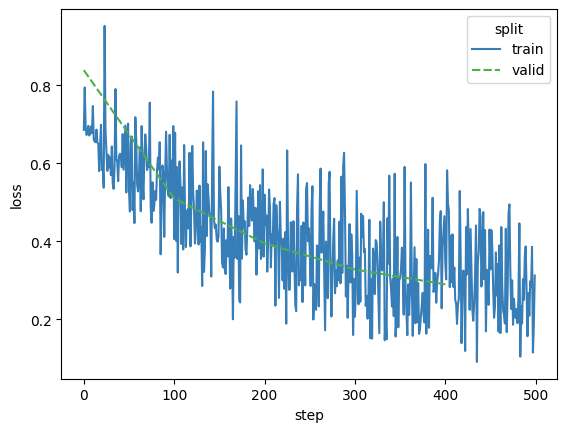

In [45]:
import matplotlib.pyplot as plt 
import seaborn as sns

from dlfb.utils.metric_plots import DEFAULT_SPLIT_COLORS

sns.lineplot(
    data=losses,
    x="step",
    y="loss",
    hue="split",
    style="split",
    palette=DEFAULT_SPLIT_COLORS
);

In [46]:
ctcf_motif_dna = "CCACCAGGGGGCGC" * 14 + "AAAA"
print("Length of CTCF motif-filled DNA string:", len(ctcf_motif_dna))

# we add the None here as a batch axis, since our model expects batched input.
ctcf_input = dna_to_one_hot(ctcf_motif_dna)[None, :]
ctcf_input.shape

Length of CTCF motif-filled DNA string: 200


(1, 200, 4)

In [47]:
jax.nn.sigmoid(model.apply({"params": state.params}, ctcf_input))

Array([[0.9998636]], dtype=float32)

In [48]:
random_dna_strings = [
    "A" * 200,
    "C" * 200,
    "G" * 200,
    "T" * 200,
    "ACGTACGT" * 25,
    "TCGATCGT" * 25,
    "TATACGCG" * 25,
    "CAGGCAGG" * 25,
]

probabilities = []

for random_dna_string in random_dna_strings:
    random_dna_input = dna_to_one_hot(random_dna_string)[None, :]

    probabilities.append(
        jax.nn.sigmoid(model.apply({"params": state.params}, random_dna_input))[0]
    )

probabilities

[Array([0.8454059], dtype=float32),
 Array([0.13529108], dtype=float32),
 Array([0.00348119], dtype=float32),
 Array([0.27601495], dtype=float32),
 Array([0.04084618], dtype=float32),
 Array([0.0048636], dtype=float32),
 Array([0.0391], dtype=float32),
 Array([0.05377858], dtype=float32)]

In [49]:
# Increasing Complexity 

# The first positive example of a sequence that binds the transcription factor.
first_positive_index = np.argmax(valid_ds["labels"].flatten() == 1)

original_sequence = valid_ds["sequences"][first_positive_index].copy()
print(f'This sequence has label: {valid_ds["labels"][4]}')

This sequence has label: [1]


In [50]:
pred = nn.sigmoid(
    model.apply({"params": state.params}, original_sequence[None, :])
)
pred 

Array([[0.9795115]], dtype=float32)

In [51]:
sequence = original_sequence.copy()
print(f"Original base at index 100: {sequence[100]}")

sequence[100] = np.array([0, 1, 0, 0])
print(f"Mutated base at index 100: {sequence[100]}")

Original base at index 100: [0 0 1 0]
Mutated base at index 100: [0 1 0 0]


In [52]:
pred_with_mutation = nn.sigmoid(
    model.apply({"params": state.params}, sequence[None, :])
)
pred_with_mutation # in sillico mutagenesis

Array([[0.96523005]], dtype=float32)

In [53]:
def generate_all_mutations(sequence: np.ndarray) -> np.ndarray:
    """generate all possible single base mutations of a one-hot DNA sequence."""
    mutated_sequences = []
    for i in range(sequence.shape[0]):
        # At each position, one of the four 'mutations' is the original base (no-op). 
        for j in range(4):
            mutated_sequence = sequence.copy()
            mutated_sequence[i] = np.zeros(4)
            mutated_sequence[i][j] = 1
            mutated_sequences.append(mutated_sequence)
    sequences = np.stack(mutated_sequences)
    return sequences

mutated_sequences = generate_all_mutations(sequence=original_sequence.copy())
print(f"Shape of mutated sequencesL {mutated_sequences.shape}")

Shape of mutated sequencesL (800, 200, 4)


In [54]:
preds = nn.sigmoid(model.apply({"params": state.params}, mutated_sequences))

# Reshape to get the shape (sequence_length, dna_bases). 
preds = preds.reshape((200, 4))

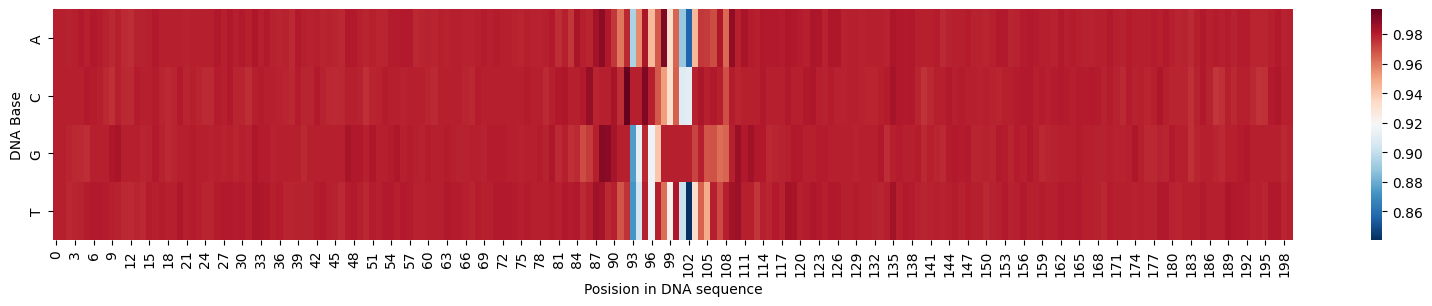

In [55]:
plt.figure(figsize=(20, 3))
sns.heatmap(preds.T, cmap="RdBu_r", yticklabels=["A", "C", "G", "T"])
plt.xlabel("Posision in DNA sequence")
plt.ylabel("DNA Base");

Text(220.72222222222223, 0.5, 'DNA Base')

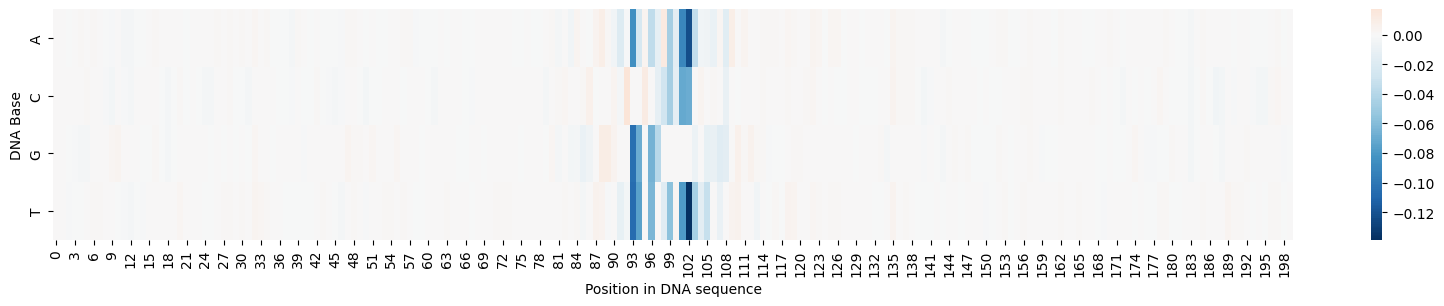

In [56]:
baseline_pred = nn.sigmoid(
    model.apply({"params": state.params}, original_sequence[None, :])
)
deltas = preds - baseline_pred

plt.figure(figsize=(20, 3))
sns.heatmap(deltas.T, center=0, cmap="RdBu_r", yticklabels=["A", "C", "G", "T"])
plt.xlabel("Position in DNA sequence")
plt.ylabel("DNA Base")

In [57]:
from dlfb.dna.inspect import describe_change
for i in range(4):
    print(describe_change((100, i), deltas, original_sequence))

position 100 with G→A (-1.54% decrease)
position 100 with G→C (-1.43% decrease)
position 100 with G→G (0.00% increase)
position 100 with G→T (0.27% increase)


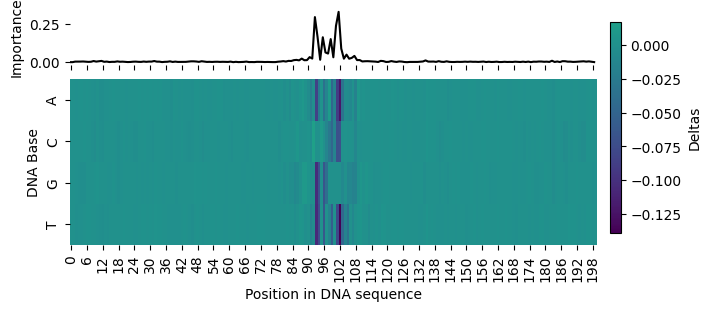

In [58]:
from dlfb.dna.inspect import plot_binding_site

importance = np.sum(np.abs(deltas), axis=1)
plot_binding_site(
    panels = {
        "tiles": {"label": "Deltas", "values": deltas},
        "line": {"label": "Importance", "values": importance},
    }
);

In [59]:
def one_hot_to_dna(one_hot_encoded: np.ndarray) -> str:
    """Convert one-hot encoded array back to DNA sequence."""
    one_hot_to_base = {
        (1, 0, 0, 0): "A",
        (0, 1, 0, 0): "C",
        (0, 0, 1, 0): "G",
        (0, 0, 0, 1): "T",
        (1, 1, 1, 1): "N" # N represents any unknown or ambiguous base.
    }

    dna_sequence = "".join(
        one_hot_to_base[tuple(base)] for base in one_hot_encoded
    )
    return dna_sequence

In [60]:
print(one_hot_to_dna(original_sequence)[0: 25], "...")

ACCCCAGGGTAGGGCCTATTGTATG ...


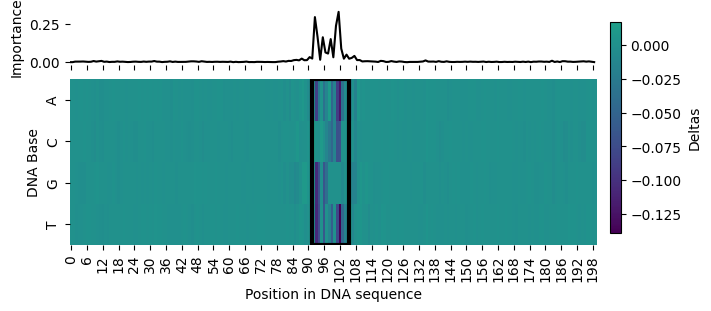

In [61]:
plot_binding_site(
    panels = {
        "tiles": {"label": "Deltas", "values": deltas},
        "line": {"label": "Importance", "values": importance},
    },
    highlight=(92, 106),
);

In [62]:
# another method, cheaper: implementing input gradients
@jax.jit
def compute_input_gradient(state, sequence):
    """Compute input gradient for a one-hot DNA sequence."""
    if len(sequence.shape) != 2:
        raise ValueError("Input must be a single one-hot encoded DNA sequence.")

    sequence = jnp.asarray(sequence, dtype=jnp.float32)[None, :]

    def predict(sequence):
        # We take the mean to ensure we have a single scalar to take the grad of.
        return jnp.mean(state.apply_fn({"params":state.params}, sequence))
    
    gradient = jax.grad(lambda x: predict(x))(sequence)
    return jnp.squeeze(gradient)

In [63]:
input_gradient = compute_input_gradient(state, original_sequence)
input_gradient.shape

(200, 4)

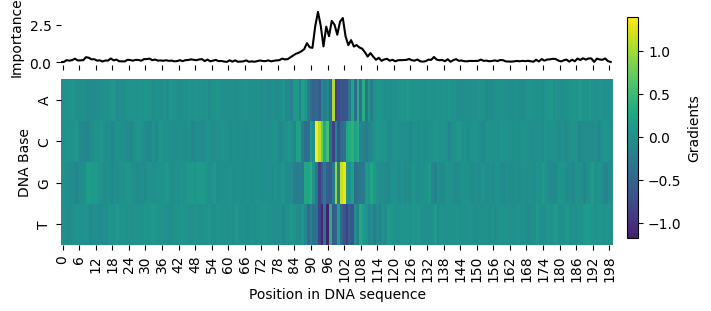

In [64]:
importance = np.sum(np.abs(input_gradient), axis=1)
plot_binding_site(
    panels = {
        "tiles": {"label": "Gradients", "values": input_gradient},
        "line": {"label": "Importance", "values": importance},
    },
);

Central DNA sequence with high importance:  TGGCCTCTGGGGGCGCTCTG


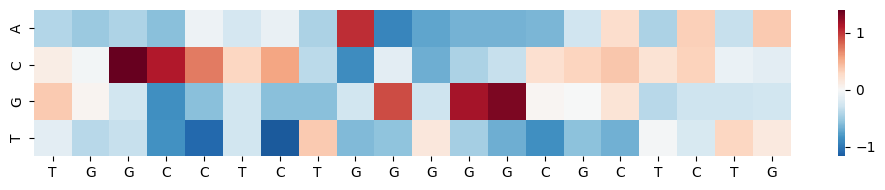

In [65]:
# to examine this region (90:110) more closely, we can zoom in and label the actual bases:

important_sequence = one_hot_to_dna(original_sequence)[90:110]
print("Central DNA sequence with high importance: ", important_sequence)

plt.figure(figsize=(10, 2))
sns.heatmap(
    input_gradient[90:110].T,
    cmap="RdBu_r",
    center=0,
    xticklabels=important_sequence,
    yticklabels=["A", "C", "G", "T"],
)
plt.tight_layout();

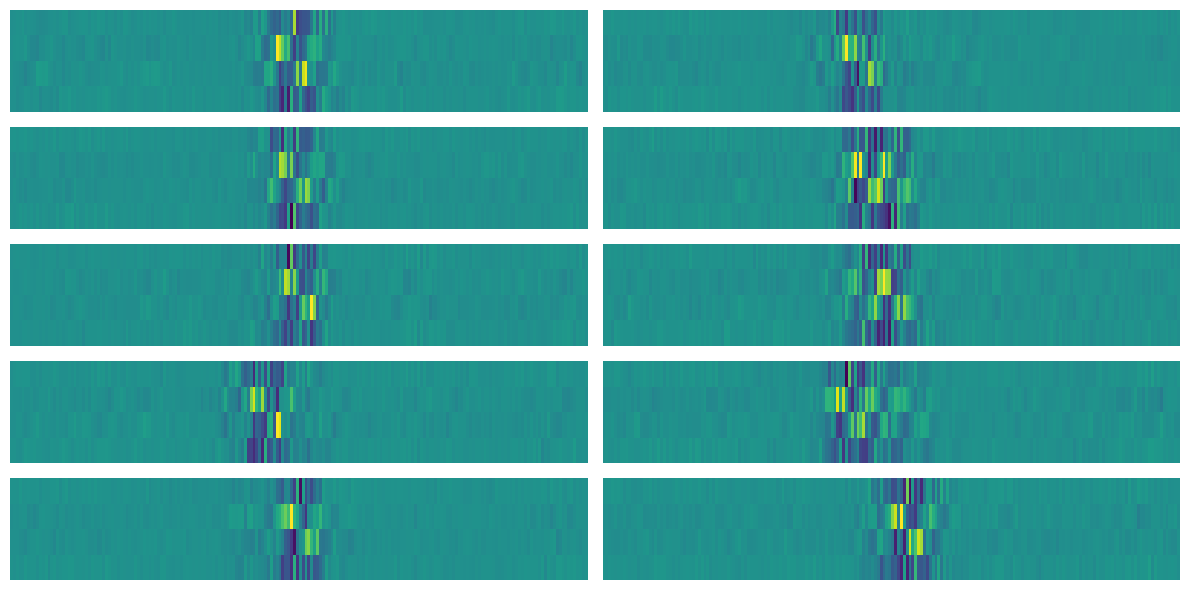

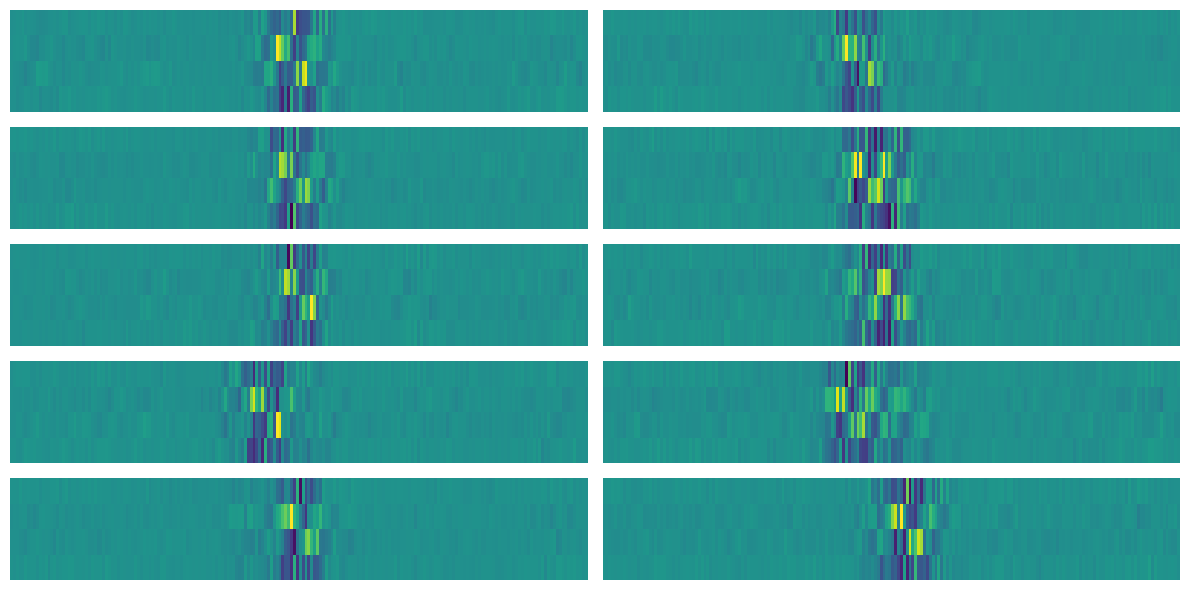

In [66]:
from dlfb.dna.inspect import plot_10_gradients
plot_10_gradients(state, valid_ds, target_label=1)

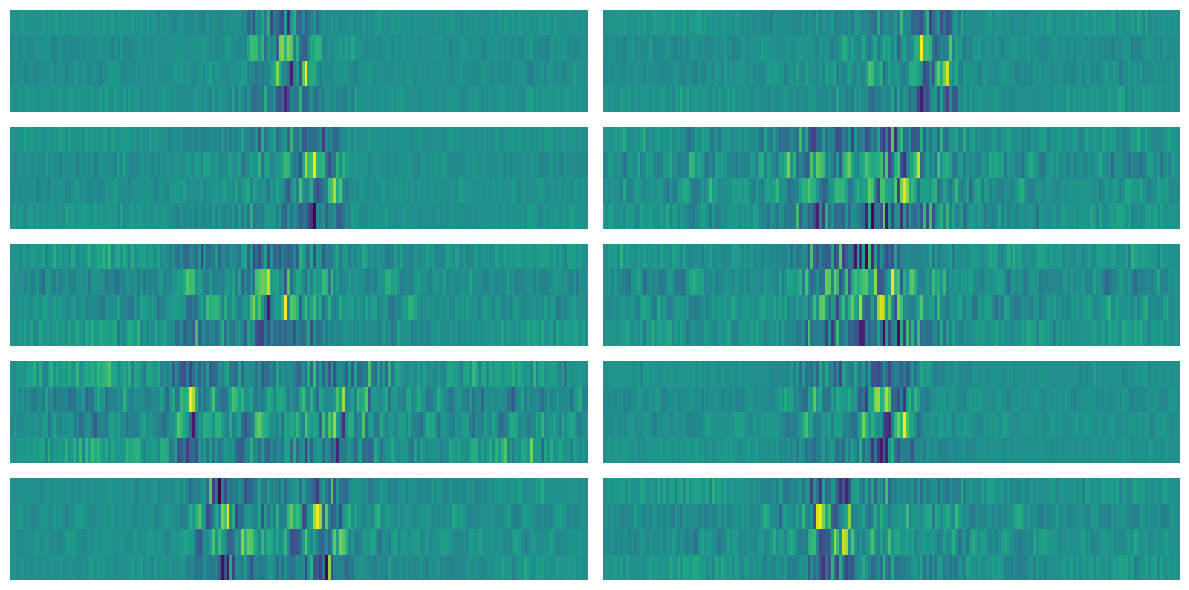

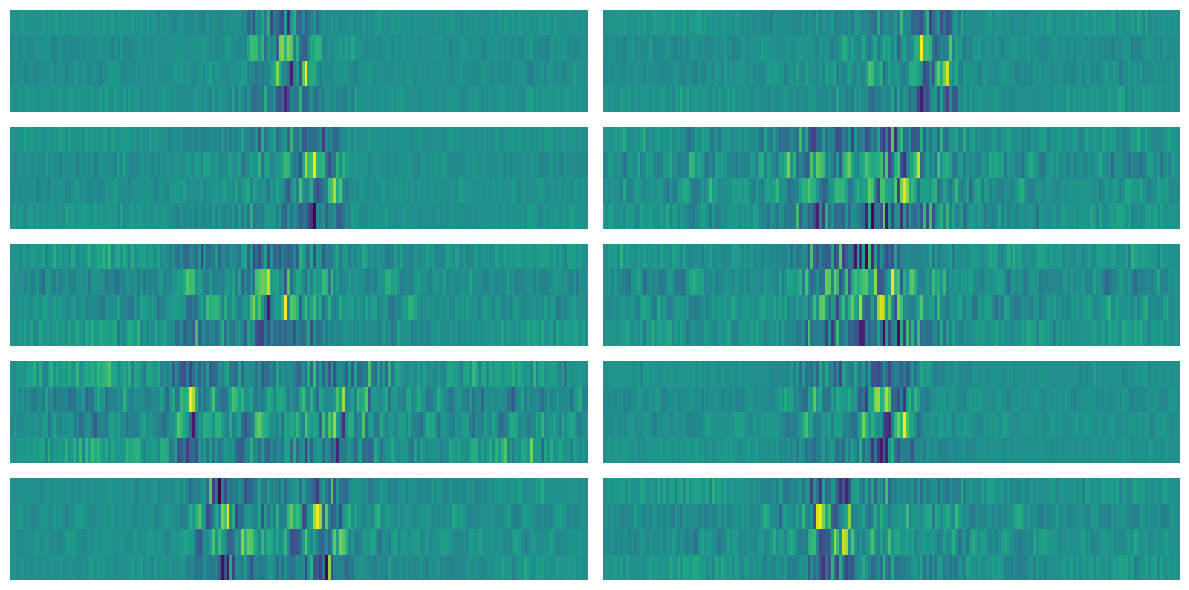

In [67]:
plot_10_gradients(state, valid_ds, target_label=0)

# Modeling Multiple Transcription Factors

In [68]:
from dlfb.dna.model import TrainStateWithBatchNorm


class ConvModelV2(nn.Module):
    """CNN with batch norm and dropout for binary classification"""

    conv_filters: int = 64 # Number of filters for conv layers.
    kernel_size: tuple[int] = (10, ) # Kernel size for 1D conv layers.
    dense_units: int = 128 # Units in first dense fully-connected layer.
    dropout_rate: float = 0.2 # Proportion of dense neurons to randomly drop out.

    @nn.compact
    def __call__(self, x, is_training: bool = True):
        # First convolutional layer.
        x = nn.Conv(
            features=self.conv_filters, kernel_size=self.kernel_size, padding="SAME"
        )(x)
        x = nn.BatchNorm(use_running_average=not is_training)(x)
        x = nn.gelu(x)
        x = nn.max_pool(x, window_shape=(2, ), strides=(2, ))

        # Second convolutional layer.
        x = nn.Conv(
            features=self.conv_filters, kernel_size=self.kernel_size, padding="SAME"
        )(x)
        x = nn.gelu(x)
        x = nn.BatchNorm(use_running_average=not is_training)(x)
        x = nn.max_pool(x, window_shape=(2, ), strides=(2, ))

        # Flatten the values before passing them to the dense layers.
        x = x.reshape((x.shape[0], -1))

        # First dense layer.
        x = nn.Dense(self.dense_units)(x)
        x = nn.gelu(x)
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not is_training)

        # Second dense layer.
        x = nn.Dense(self.dense_units // 2)(x)
        x = nn.gelu(x)
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not is_training)

        # Output layer (single unit for binary classification)
        return nn.Dense(1)(x)
    
    def create_train_state(self, rng: jax.Array, dummy_input, tx):
        """Initializes model parameters and returns a train state for training"""
        rng, rng_init, rng_dropout = jax.random.split(rng, 3)
        variables = self.init(rng_init, dummy_input)
        state = TrainStateWithBatchNorm.create(
            apply_fn=self.apply,
            tx=tx,
            params=variables["params"],
            batch_stats=variables['batch_stats'],
            key=rng_dropout,
        )
        return state 


Text(0.5, 0, 'Step')

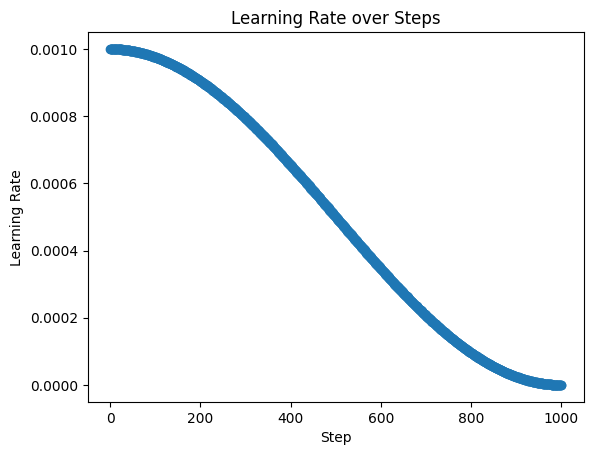

In [69]:
num_steps = 1000
scheduler = optax.cosine_decay_schedule(
    init_value=0.001,
    decay_steps=num_steps, # How long to decay over.
)
learning_rates = [scheduler(i) for i in range(num_steps)]

plt.scatter(range(num_steps), learning_rates)
plt.title("Learning Rate over Steps")
plt.ylabel("Learning Rate")
plt.xlabel("Step")

In [70]:
rng = jax.random.PRNGKey(42)
rng, rng_init, rng_train = jax.random.split(rng, 3)
state = ConvModelV2().create_train_state(
    rng=rng_init, dummy_input=batch["sequences"], tx=optax.adam(scheduler)
)

In [71]:
@jax.jit
def train_step(state, batch, rng_dropout: jax.Array):
    """Run a training step and update parameters"""

    def calculate_loss(params, batch):
        """Make predictions on batch and compute binary cross-entropy loss."""
        logits, updates = state.apply_fn(
            {"params": params, "batch_stats": state.batch_stats},
            x=batch["sequences"],
            is_training=True,
            rngs={"dropout": rng_dropout},
            mutable=["batch_stats"],
        )
        loss = optax.sigmoid_binary_cross_entropy(logits, batch["labels"]).mean()
        return loss, updates
    
    grad_fn = jax.value_and_grad(calculate_loss, has_aux=True)
    (loss, updates), grads = grad_fn(state.params, batch)
    state = state.apply_gradients(grads=grads)
    state = state.replace(batch_stats=updates["batch_stats"])

    metrics = {"loss": loss}
    
    return state, metrics

In [72]:
# Overfit on one batch
for i in range(5):
    rng, rng_dropout = jax.random.split(rng, 2)
    state, metrics = train_step(state, batch, rng_dropout)
    print(f"Step {i} loss: {metrics['loss']}")

Step 0 loss: 0.7608155012130737
Step 1 loss: 0.2602437138557434
Step 2 loss: 0.11353784799575806
Step 3 loss: 0.050131045281887054
Step 4 loss: 0.04660031199455261


In [73]:
from dlfb.dna.train import compute_metrics
from sklearn.metrics import roc_auc_score, accuracy_score

def eval_step(state, batch):
    """Evalulate model on a single batch"""
    logits = state.apply_fn(
        {"params": state.params, "batch_stats": state.batch_stats},
        x=batch["sequences"],
        is_training=False,
        mutable=False,
    )
    loss = optax.sigmoid_binary_cross_entropy(logits, batch["labels"]).mean()
    metrics = {
        "loss": loss.item(),
        **compute_metrics(batch["labels"], logits),
    }
    return metrics

def compute_metrics(y_true: np.ndarray, logits: np.ndarray):
    """Compute accuracy and auROC for model predictions"""
    metrics = {
        "accuracy": accuracy_score(y_true, nn.sigmoid(logits) >= 0.5),
        "auc": roc_auc_score(y_true, logits).item(),
    }
    return metrics 

c:\Users\justc\anaconda3\envs\dl4b\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [74]:
# Evaluate the batch.
metrics = eval_step(state, batch)
print(metrics)

{'loss': 0.5078951120376587, 'accuracy': 1.0, 'auc': 1.0}


In [96]:
from typing import Any
from dlfb.utils.metrics_logger import MetricsLogger
from dlfb.utils.restore import restorable
import tensorflow as tf
@restorable
def train(
    state: TrainStateWithBatchNorm,
    rng: jax.Array,
    dataset_splits: dict[str, tf.data.Dataset],
    num_steps: int,
    eval_every: int = 100,
) -> tuple[TrainStateWithBatchNorm, Any]:
    """Train a model and log metrics over steps."""
    metrics = MetricsLogger()
    train_batches = dataset_splits["train"].as_numpy_iterator()

    steps = tqdm.tqdm(range(num_steps)) # pyright: ignore[reportCallIssue] # Steps with progress bar.
    for step in steps:
        steps.set_description(f"Step {step + 1}")
        
        rng, rng_dropout = jax.random.split(rng, 2)
        train_batch = next(train_batches)
        state, batch_metrics = train_step(state, train_batch, rng_dropout)
        metrics.log_step(split="train", **batch_metrics)

        if step % eval_every == 0:
            for eval_batch in dataset_splits["valid"].as_numpy_iterator():
                batch_metrics = eval_step(state, eval_batch)
                metrics.log_step(split="valid", **batch_metrics)
            metrics.flush(step=step)
        
        steps.set_postfix_str(metrics.latest(["loss"]))
    return state, metrics.export() # pyright: ignore[reportAttributeAccessIssue]

In [76]:
def load_dataset_splits(path, transcription_factor, batch_size: int | None = None):
    """Load TF dataset splits (train, valid, test) as TensorFlow datasets."""
    dataset_splits = {}
    for split in ["train", "valid", "test"]:
        dataset = load_dataset(
            sequence_db=f"{path}/{transcription_factor}_{split}_sequences.csv"
        )
        ds = convert_to_tfds(dataset, batch_size, is_training=(split == "train"))
        dataset_splits.update({split: ds})
    return dataset_splits

In [77]:
transcription_factors = [
    "ARID3",
    "ATF2",
    "BACH1",
    "CTCF",
    "ELK1",
    "GABPA",
    "MAX",
    "REST",
    "SRF",
    "ZNF24",
]

In [78]:
prefix = r"C:\Users\justc\Documents\ml-study-notes\dlfb-clone\assets\dna\datasets" 
tf_metrics = {}

# Train one model per transcription factor.
for transcription_factor in transcription_factors: 
    # Load data for this TF
    dataset_splits = load_dataset_splits(r"C:\Users\justc\Documents\ml-study-notes\dlfb-clone\assets\dna\datasets", transcription_factor, batch_size)
    rng = jax.random.PRNGKey(42)
    rng, rng_init, rng_train = jax.random.split(rng, 3)
    dummy_batch = next(dataset_splits["train"].as_numpy_iterator())["sequences"]

    # Create train state.
    state = ConvModelV2().create_train_state(
        rng = rng_init,
        dummy_input = dummy_batch,
        tx = optax.adam(scheduler),
    )
    
    # Train the model.
    _, metrics = train(
        state=state,
        rng= rng_train,
        dataset_splits = dataset_splits,
        num_steps = num_steps,
        eval_every = 100,
        store_path = f"C:/Users/justc/Documents/ml-study-notes/dlfb-clone/assets/dna/models/{transcription_factor}", 
    )

    tf_metrics.update({transcription_factor: metrics})

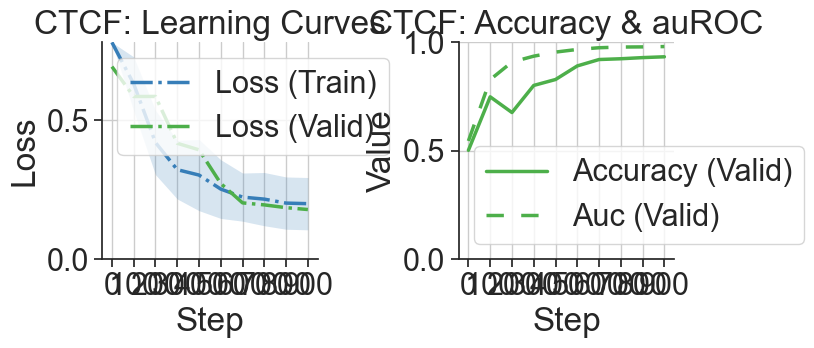

In [88]:
from dlfb.dna.inspect import plot_learning

tfp = "CTCF"
plot_learning(tf_metrics[tfp], tfp);

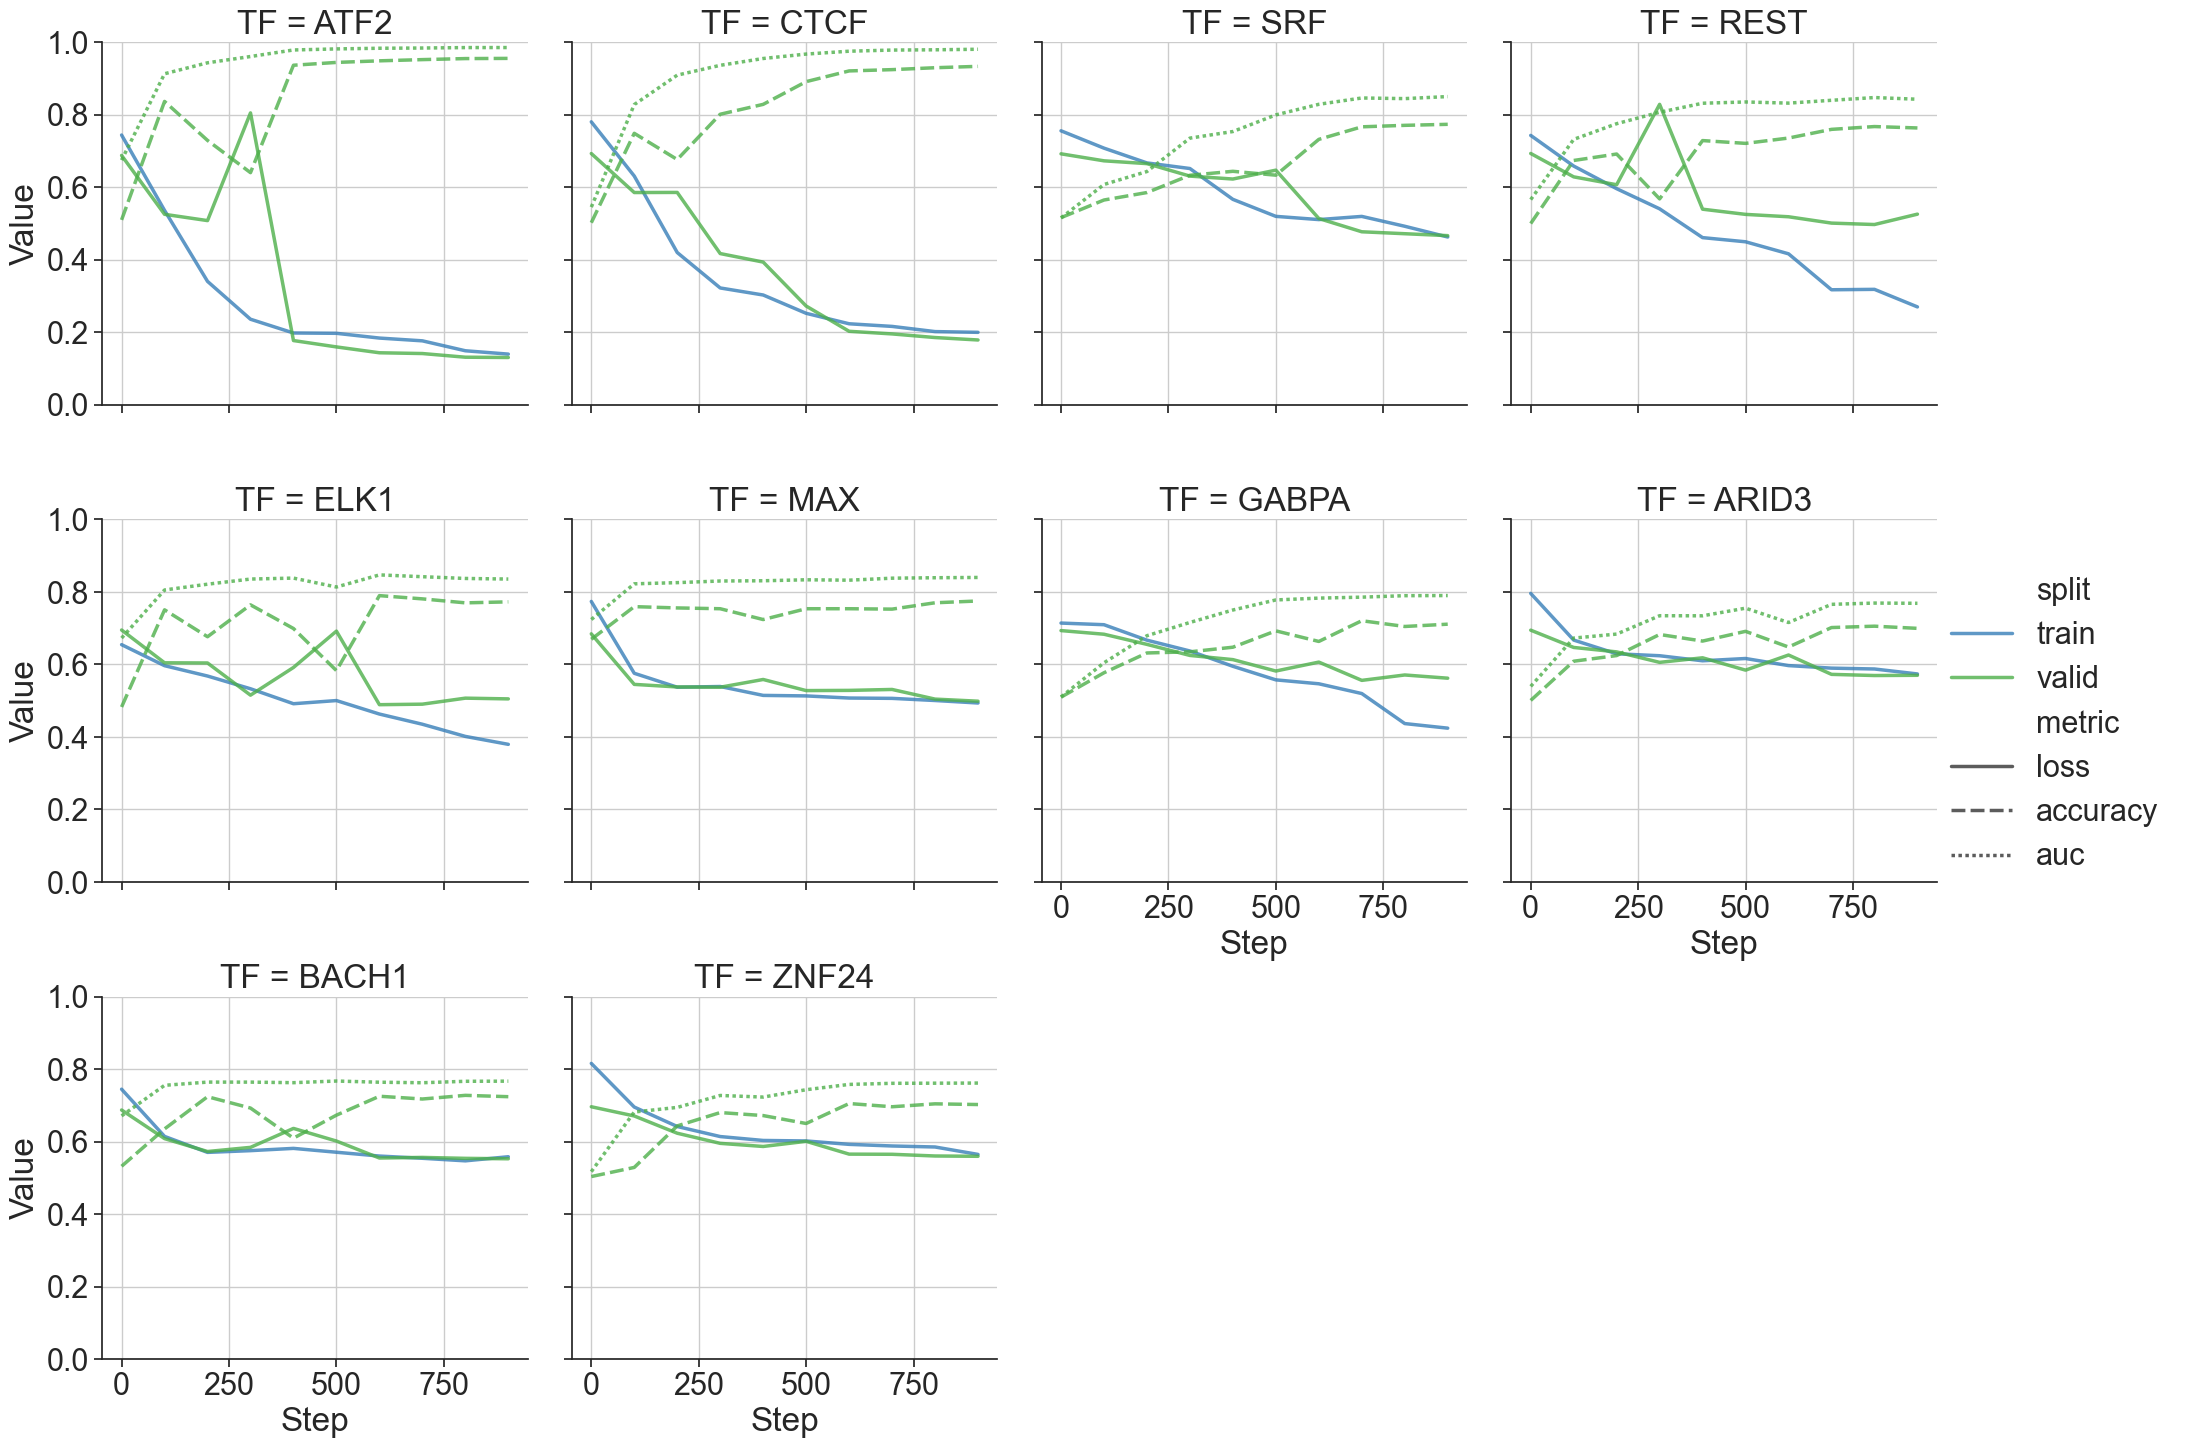

In [80]:
from dlfb.utils.metric_plots import to_df

# Extract metrics logged per transcription factor.
tf_df = []
for tf, metrics in tf_metrics.items():
    tf_df.append(to_df(metrics).assign(TF=tf))
tf_df = pd.concat(tf_df)

# Determine order of best performance.
auc_df = tf_df[(tf_df["metric"] == "auc") & (tf_df["split"] == "valid")]
max_auc_by_tf = auc_df.groupby("TF")["mean"].max()
tf_order = max_auc_by_tf.sort_values(ascending=False).index.tolist()
tf_df["TF"] = pd.Categorical(tf_df["TF"], categories=tf_order, ordered=True)

sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
sns.set_style("ticks", {"axes.grid": True})
g = sns.relplot(
    data = tf_df,
    x="round",
    y="mean",
    hue="split",
    style="metric",
    kind="line",
    col="TF",
    col_order=tf_order,
    col_wrap=4,
    alpha=0.8,
    palette=DEFAULT_SPLIT_COLORS,
    dashes=True,
)
g.set_axis_labels("Step", "Value")
g.set(ylim=(0, 1))

Figure 3.18) Learning curves for all 10 TFs. Each panel shows the training and validation loss (solid lines), validation accuracy (dashed lines), and validation auROC (dotted lines) over training steps. TFs are ordered by peak auROC performance. While some TFs, like CTCF and ATF2, reach near-perfect performance quickly, others, such as ZNF24 and BACH1, prove more challenging to model.

In [81]:
print(max_auc_by_tf.sort_values(ascending=False))

TF
ATF2     0.985182
CTCF     0.980479
SRF      0.849944
REST     0.847251
ELK1     0.846878
MAX      0.839834
GABPA    0.789892
ARID3    0.769149
BACH1    0.767122
ZNF24    0.761506
Name: mean, dtype: float64


# Advanced Techniques

Let's modularize our convolutional and MLP layers by creating two helper modules, ConvBlock and MLPBlock

In [82]:
class ConvBlock(nn.Module):
    """Convolutional block with batch norm, GELU and max pooling."""

    conv_filters: int
    kernel_size: tuple[int]
    pool_size: int

    @nn.compact
    def __call__(self, x, is_training: bool = True):
        x = nn.Conv(
            features=self.conv_filters, kernel_size=self.kernel_size, padding="SAME",
        )(x)
        x = nn.BatchNorm(use_running_average=not is_training)(x)
        x = nn.gelu(x)
        x = nn.max_pool(
            x, window_shape=(self.pool_size,), strides=(self.pool_size,)
        )
        return x
    
class MLPBlock(nn.Module):
    """Dense + GELU + dropout block."""

    dense_units: int
    dropout_rate: float = 0.0

    @nn.compact 
    def __call__(self, x, is_training: bool = True):
        x = nn.Dense(self.dense_units)(x)
        x = nn.gelu(x)
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not is_training)
        return x

With these reusable blocks in place, we can define a more compact and configurable model architecture!

In [101]:
class TransformerBlock(nn.Module):
    """Transformer block with self-attention and MLP"""

    num_heads: int = 8
    dense_units: int = 64
    dropout_rate: float = 0.2

    @nn.compact
    def __call__(self, x, is_training: bool = True):
        # Self-attention with layer norm.
        residual = x
        x = nn.LayerNorm()(x)
        x = nn.SelfAttention(num_heads=self.num_heads)(x)
        x += residual

        # Feedforward block
        residual = x
        x = nn.LayerNorm()(x)
        x = nn.Dense(self.dense_units)(x)
        x = nn.gelu(x)
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not is_training)
        x = nn.Dense(self.dense_units)(x) # No GELU after this Dense.   
        x += residual
        return x

In [102]:
class ConvTransformerModel(nn.Module):
    """Model combining CNN, transformer, and MLP blocks"""

    num_conv_blocks: int = 2
    conv_filters: int = 64
    kernel_size: tuple[int] = (10, )
    num_mlp_blocks: int = 2
    dense_units: int = 128
    dropout_rate: float = 0.2 # Global.
    num_transformer_blocks: int = 0
    num_transformer_heads: int  = 8
    transformer_dense_units: int = 64

    @nn.compact
    def __call__(self, x, is_training: bool = True):
        for _ in range(self.num_conv_blocks):
            x = ConvBlock(
                conv_filters=self.conv_filters,
                kernel_size=self.kernel_size,
                pool_size=2,
            )(x, is_training)

        for i in range(self.num_transformer_blocks):
            x = TransformerBlock(
                num_heads=self.num_transformer_heads,
                dense_units=self.transformer_dense_units,
                dropout_rate=self.dropout_rate,
            )(x, is_training)

        x = x.reshape((x.shape[0], -1))

        for i in range(self.num_mlp_blocks):
            x = MLPBlock(
                dense_units=self.dense_units // (i + 1), dropout_rate = self.dropout_rate
            )(x, is_training)
        
        return nn.Dense(1)(x)
    
    def create_train_state(self, rng: jax.Array, dummy_input, tx):
        """Initializes model parameters and returns a train state for training"""
        rng, rng_init, rng_dropout = jax.random.split(rng, 3)
    
        # Use proper RNG dict for Flax
        variables = self.init(
            {'params': rng_init, 'dropout': rng_dropout}, 
            dummy_input,
            is_training=True
        )
    
        state = TrainStateWithBatchNorm.create(
            apply_fn=self.apply,
            tx=tx,
            params=variables["params"],
            batch_stats=variables.get('batch_stats', {}),
            key=rng_dropout,
        )
        return state

In [122]:
models = {
    # Our standard 2-layer CNN with dropout and MLP.
    'baseline': ConvTransformerModel(),
    # Ablations: Remove or reduce certain components.
    # Only a single convolutional block.
    "single_conv_only": ConvTransformerModel(
        num_conv_blocks=1, num_transformer_blocks=0, num_mlp_blocks=0
    ),
    # Reduced capacity by lowering conv filters.
    "fewer_conv_channels": ConvTransformerModel(conv_filters=8),
    # Drop the MLP layers to test if they help.
    "remove_MLP": ConvTransformerModel(num_mlp_blocks=0),
    # Potential improvements: Add more expressive capacity.
    # Add a transformer block after convolutions.
    "add_one_transformer_block": ConvTransformerModel(num_transformer_blocks=1),
    # Stack two transformer blocks.
    "add_two_transformer_block": ConvTransformerModel(num_transformer_blocks=2),
}

In [120]:
models.items()

dict_items([('baseline', ConvTransformerModel(
    # attributes
    num_conv_blocks = 2
    conv_filters = 64
    kernel_size = (10,)
    num_mlp_blocks = 2
    dense_units = 128
    dropout_rate = 0.2
    num_transformer_blocks = 0
    num_transformer_heads = 8
    transformer_dense_units = 64
)), ('single_conv_only', ConvTransformerModel(
    # attributes
    num_conv_blocks = 1
    conv_filters = 64
    kernel_size = (10,)
    num_mlp_blocks = 0
    dense_units = 128
    dropout_rate = 0.2
    num_transformer_blocks = 0
    num_transformer_heads = 8
    transformer_dense_units = 64
)), ('fewer_conv_channels', ConvTransformerModel(
    # attributes
    num_conv_blocks = 2
    conv_filters = 8
    kernel_size = (10,)
    num_mlp_blocks = 2
    dense_units = 128
    dropout_rate = 0.2
    num_transformer_blocks = 0
    num_transformer_heads = 8
    transformer_dense_units = 64
)), ('remove_MLP', ConvTransformerModel(
    # attributes
    num_conv_blocks = 2
    conv_filters = 64
    ke

In [121]:
import shutil
from pathlib import Path

# Delete old checkpoints before training
base_model_path = "C:/Users/justc/Documents/ml-study-notes/dlfb-clone/assets/dna/models"
model_dir = Path(base_model_path)

if model_dir.exists():
    shutil.rmtree(model_dir)
    print(f"Deleted old checkpoints at {model_dir}")

Deleted old checkpoints at C:\Users\justc\Documents\ml-study-notes\dlfb-clone\assets\dna\models


In [123]:
import tensorflow as tf
# Train and evaludate multiple model architectures on the ZNF24 dataset.
transcription_factor = "ZNF24"
dataset_splits = load_dataset_splits(r"C:\Users\justc\Documents\ml-study-notes\dlfb-clone\assets\dna\datasets", transcription_factor, batch_size)

# Prepare a dummy input for model initialization.
dummy_input = next(dataset_splits["train"].as_numpy_iterator())["sequences"]

# Initialize PRNGs.
rng = jax.random.PRNGKey(42)
rng, rng_init, rng_train = jax.random.split(rng, 3)

# Dictionaries to store metrics for each model variant.
model_metrics = {}

# Train each model varaint and store its metrics.
for name, model in models.items():
    state = model.create_train_state(
        rng=rng_init,
        dummy_input=dummy_input,
        tx=optax.adam(
            optax.cosine_decay_schedule(
                init_value=learning_rate,
                decay_steps=num_steps,
            )
        ),
    )
    _, metrics = train(
        state=state,
        rng=rng_train,
        dataset_splits=dataset_splits,
        num_steps=num_steps,
        eval_every=100,
        store_path=f"C:/Users/justc/Documents/ml-study-notes/dlfb-clone/assets/dna/models/{name}",
    )
    model_metrics.update({name: metrics})

# Etract metrics logge dfor transcription factor.
model_df = []
for model, metrics in model_metrics.items():
    model_df.append(to_df(metrics).assign(model=model))
model_df = pd.concat(model_df)

# Determine order of best performance.
auc_df = model_df[
    (model_df["metric"] == "auc") & (model_df["split"] == "valid")
]
max_auc_by_model = auc_df.groupby("model")["mean"].max()
model_order = max_auc_by_model.sort_values(ascending=False).index.tolist()
model_df["model"] = pd.Categorical(
    model_df["model"], categories=model_order, ordered=True,
)


Step 1000: 100%|██████████| 1000/1000 [01:53<00:00,  8.84it/s, loss: train=0.5449±0.0719, valid=0.5503±0.0760]


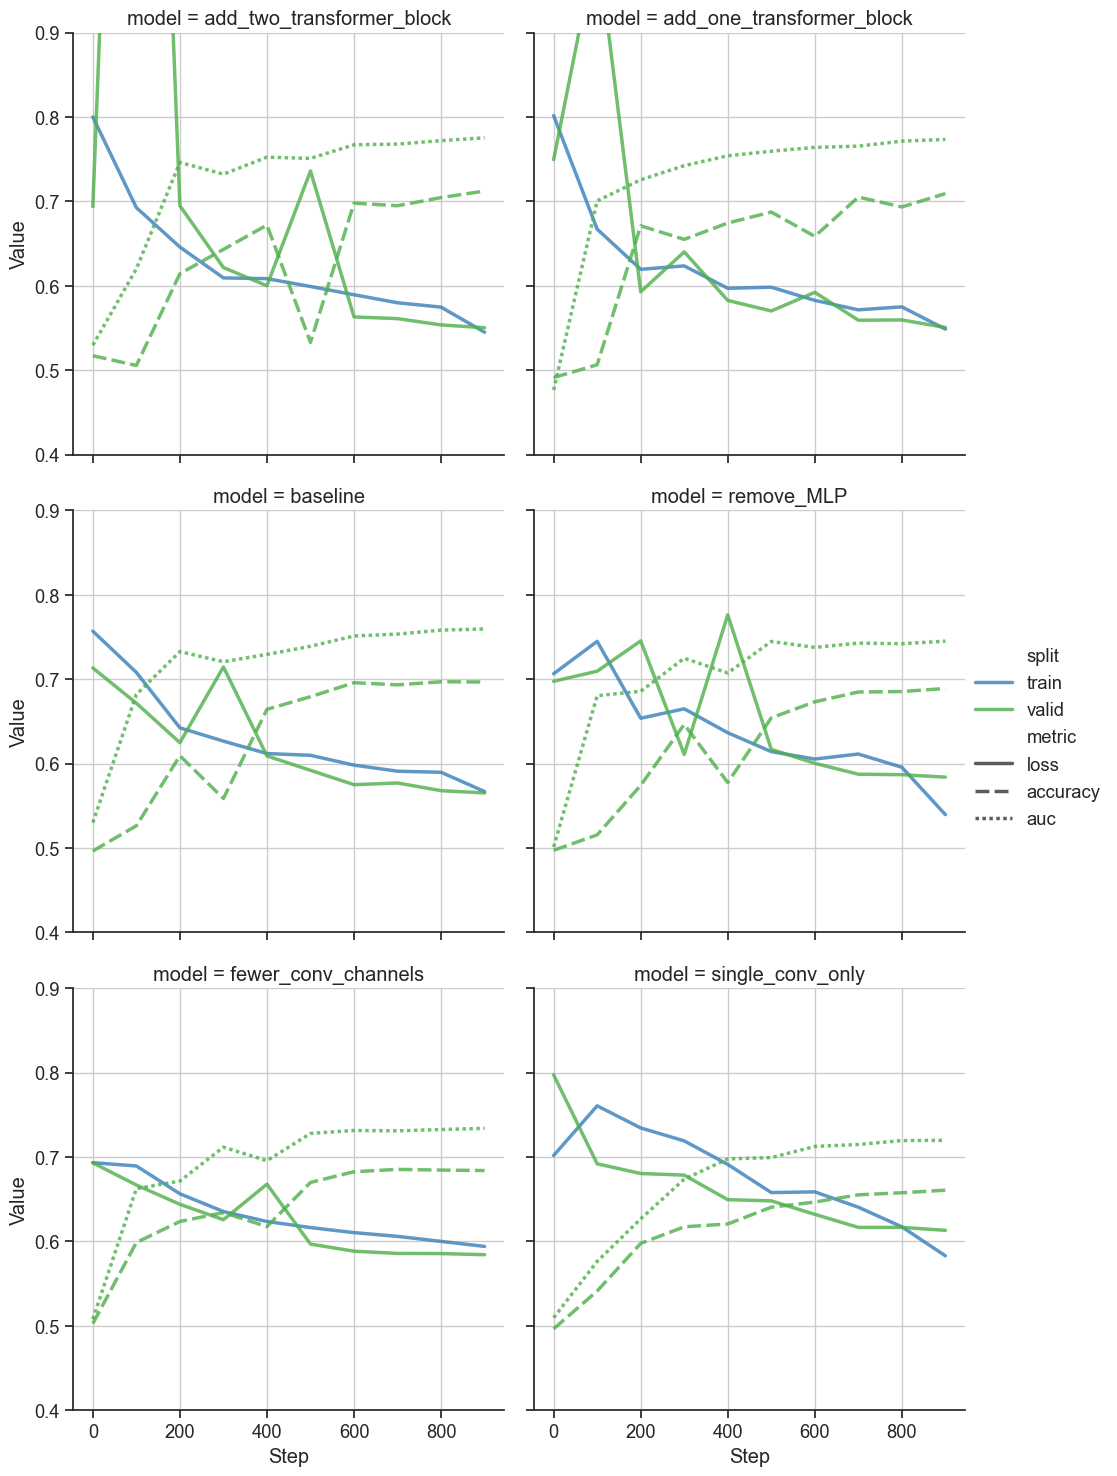

In [124]:
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
sns.set_style("ticks", {"axes.grid": True})
g = sns.relplot(
    data=model_df,
    x="round",
    y="mean",
    hue="split",
    style="metric",
    kind="line",
    col="model",
    col_order=model_order,
    col_wrap=2,
    alpha=0.8,
    palette=DEFAULT_SPLIT_COLORS,
    dashes=True,
)
g.set_axis_labels("Step", "Value")
g.set(ylim=(0.4, 0.9));

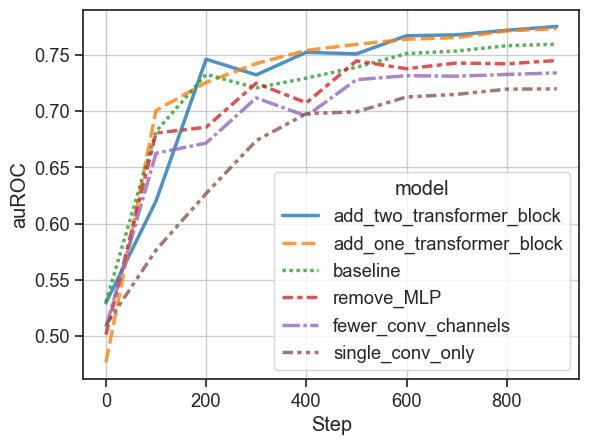

In [125]:
g = sns.lineplot(
    data=model_df[(model_df["metric"] == "auc")],
    x="round",
    y="mean",
    hue="model",
    style="model",
    alpha=0.8,
)
g.set_xlabel("Step")
g.set_ylabel("auROC");

In [117]:
print(max_auc_by_model.sort_values(ascending=False))

model
add_two_transformer_block    0.769951
add_one_transformer_block    0.766986
baseline                     0.759057
remove_MLP                   0.753302
fewer_conv_channels          0.729267
single_conv_only             0.722451
Name: mean, dtype: float64


# Evaluating on the Test Split: failed with error - git contribution with fix needed(if time allows)

In [131]:
from dlfb.utils.restore import restore

top_model = model_order[0]
# Now retrain or reload
state, _ = restore(
    f"C:/Users/justc/Documents/ml-study-notes/dlfb-clone/assets/dna/models/{top_model}",
    models[top_model].create_train_state(
        rng=rng_init,
        dummy_input=next(dataset_splits["train"].as_numpy_iterator())["sequences"],
        tx=optax.adamw(
            optax.cosine_decay_schedule(
                init_value=learning_rate,
                decay_steps=num_steps,
            )
        ),
    ),
)

ValueError: List arity mismatch: 3 != 2; list: [{'count': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('int32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(), shape=(), strict=True), 'mu': {'ConvBlock_0': {'BatchNorm_0': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'scale': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True)}, 'Conv_0': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(10, 4, 64), shape=(10, 4, 64), strict=True)}}, 'ConvBlock_1': {'BatchNorm_0': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'scale': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True)}, 'Conv_0': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(10, 64, 64), shape=(10, 64, 64), strict=True)}}, 'Dense_0': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(1,), shape=(1,), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64, 1), shape=(64, 1), strict=True)}, 'MLPBlock_0': {'Dense_0': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(128,), shape=(128,), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(3200, 128), shape=(3200, 128), strict=True)}}, 'MLPBlock_1': {'Dense_0': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(128, 64), shape=(128, 64), strict=True)}}, 'TransformerBlock_0': {'Dense_0': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64, 64), shape=(64, 64), strict=True)}, 'Dense_1': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64, 64), shape=(64, 64), strict=True)}, 'LayerNorm_0': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'scale': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True)}, 'LayerNorm_1': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'scale': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True)}, 'SelfAttention_0': {'key': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(8, 8), shape=(8, 8), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64, 8, 8), shape=(64, 8, 8), strict=True)}, 'out': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(8, 8, 64), shape=(8, 8, 64), strict=True)}, 'query': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(8, 8), shape=(8, 8), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64, 8, 8), shape=(64, 8, 8), strict=True)}, 'value': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(8, 8), shape=(8, 8), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64, 8, 8), shape=(64, 8, 8), strict=True)}}}, 'TransformerBlock_1': {'Dense_0': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64, 64), shape=(64, 64), strict=True)}, 'Dense_1': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64, 64), shape=(64, 64), strict=True)}, 'LayerNorm_0': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'scale': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True)}, 'LayerNorm_1': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'scale': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True)}, 'SelfAttention_0': {'key': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(8, 8), shape=(8, 8), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64, 8, 8), shape=(64, 8, 8), strict=True)}, 'out': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(8, 8, 64), shape=(8, 8, 64), strict=True)}, 'query': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(8, 8), shape=(8, 8), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64, 8, 8), shape=(64, 8, 8), strict=True)}, 'value': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(8, 8), shape=(8, 8), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64, 8, 8), shape=(64, 8, 8), strict=True)}}}}, 'nu': {'ConvBlock_0': {'BatchNorm_0': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'scale': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True)}, 'Conv_0': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(10, 4, 64), shape=(10, 4, 64), strict=True)}}, 'ConvBlock_1': {'BatchNorm_0': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'scale': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True)}, 'Conv_0': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(10, 64, 64), shape=(10, 64, 64), strict=True)}}, 'Dense_0': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(1,), shape=(1,), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64, 1), shape=(64, 1), strict=True)}, 'MLPBlock_0': {'Dense_0': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(128,), shape=(128,), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(3200, 128), shape=(3200, 128), strict=True)}}, 'MLPBlock_1': {'Dense_0': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(128, 64), shape=(128, 64), strict=True)}}, 'TransformerBlock_0': {'Dense_0': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64, 64), shape=(64, 64), strict=True)}, 'Dense_1': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64, 64), shape=(64, 64), strict=True)}, 'LayerNorm_0': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'scale': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True)}, 'LayerNorm_1': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'scale': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True)}, 'SelfAttention_0': {'key': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(8, 8), shape=(8, 8), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64, 8, 8), shape=(64, 8, 8), strict=True)}, 'out': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(8, 8, 64), shape=(8, 8, 64), strict=True)}, 'query': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(8, 8), shape=(8, 8), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64, 8, 8), shape=(64, 8, 8), strict=True)}, 'value': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(8, 8), shape=(8, 8), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64, 8, 8), shape=(64, 8, 8), strict=True)}}}, 'TransformerBlock_1': {'Dense_0': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64, 64), shape=(64, 64), strict=True)}, 'Dense_1': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64, 64), shape=(64, 64), strict=True)}, 'LayerNorm_0': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'scale': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True)}, 'LayerNorm_1': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'scale': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True)}, 'SelfAttention_0': {'key': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(8, 8), shape=(8, 8), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64, 8, 8), shape=(64, 8, 8), strict=True)}, 'out': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64,), shape=(64,), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(8, 8, 64), shape=(8, 8, 64), strict=True)}, 'query': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(8, 8), shape=(8, 8), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64, 8, 8), shape=(64, 8, 8), strict=True)}, 'value': {'bias': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(8, 8), shape=(8, 8), strict=True), 'kernel': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('float32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(64, 8, 8), shape=(64, 8, 8), strict=True)}}}}}, RestoreArgs(restore_type=None, dtype=None), {'count': ArrayRestoreArgs(restore_type=<class 'jax.Array'>, dtype=dtype('int32'), mesh=None, mesh_axes=None, sharding=SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host), global_shape=(), shape=(), strict=True)}].